In [13]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import exists
import open3d as o3d

In [14]:
folder = './cv2019_data/calib/'
files = [f'{folder}{f}' for f in os.listdir(folder)]

cameraParameters = './res/params.npz'
LOAD_PARAMETERS = False # if true load parameters from file (if it exists) else computes params from the images

OBJECTS = ['cup1', 'cup2', 'puppet', 'soap']
OBJECT_NAME = OBJECTS[0]
VIDEO_NAME = f'./cv2019_data/{OBJECT_NAME}.mp4'
SCAN_NAME = f'./res/scan_{OBJECT_NAME}.ply'

# Rectangle finder variables
RECTANGLE_SINGLE_FRAME = 1  # uses only the first frame to compute the rectangles
RECTANGLE_MULTI_FRAME = 2   # uses the average of multiple frames to compute the rectangles

# Laser mask variables
LASER_MASK_COLOR = 0        # Uses HLS color space to filter the ray out of the frame
LASER_MASK_COLOR_2 = 2      # Uses HLS but with different parameters for the filter
LASER_MASK_DIFFERENCE = 1   # Uses the difference between the frames to isolate the laser



################
# CUSTOMIZABLE #
#  VARIABLES   #
################

RECTANGLE_DEFAULT = RECTANGLE_MULTI_FRAME   # default method to detect the rectangles sheets
RECTANGLE_ITERATIONS = 5                    # number of iterations in case of multi frame
LASER_MASK_DEFAULT = LASER_MASK_COLOR_2     # default method to mask the laser
INCLUDE_PLANES_IN_SCAN = False              # should the planes be included in the final 3D render


# Camera calibration
Finding camera parameters based on the chessboards

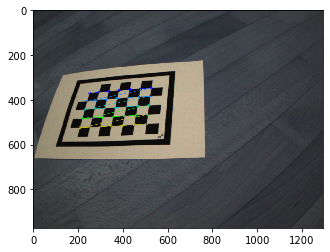

In [15]:
if LOAD_PARAMETERS and exists(cameraParameters):
    params = np.load(cameraParameters)
    mtx = params['mtx']
    dist = params['dist']
    newcameramtx = params['newcameramtx']
    roi = params['roi']

    print('Camera parameters loaded from file')
else:
    objp = np.zeros((5*7,3), np.float32)
    objp[:,:2] = np.mgrid[0:7,0:5].T.reshape(-1,2)

    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    objpoints = []
    imgpoints = []

    for c, f in enumerate(files):
        img = cv.imread(f)
        gImg = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

        # cv.imshow(f, img)
        # cv.waitKey(0) # waits until a key is pressed
        # cv.destroyAllWindows() # destroys the window showing

        ret, corners = cv.findChessboardCorners(gImg, (7,5), None)

        if ret == True:
            objpoints.append(objp)

            corners2 = cv.cornerSubPix(gImg, corners, (11,11), (-1, -1), criteria)
            imgpoints.append(corners)

            img = cv.drawChessboardCorners(img, (7,5), corners2, ret)

    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gImg.shape[::-1], None, None)

    h,  w = img.shape[:2]
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

    plt.imshow(img)
    plt.show()

    np.savez(cameraParameters, mtx = mtx, dist = dist, newcameramtx = newcameramtx, roi = roi)




## Undistort image

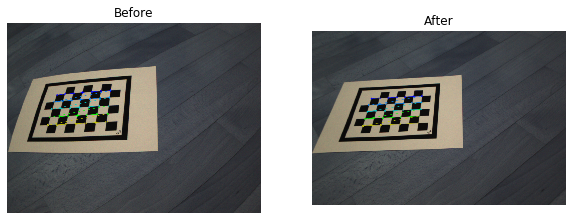

In [16]:
def undistort(img, useRoi=True, plotBeforeAndAfter=False):
    dst = cv.undistort(img, mtx, dist, None, newcameramtx)

    if useRoi:
        x, y, w, h = roi
        dst = dst[y:y+h, x:x+w] # removes black part of the image

    # Plot before and after
    if plotBeforeAndAfter:
        cv.imwrite('./res/calibresult.png', dst)

        fig = plt.figure(figsize=(10, 5))

        fig.add_subplot(1, 2, 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Before')

        fig.add_subplot(1, 2, 2)
        plt.imshow(dst)
        plt.axis('off')
        plt.title('After')

    return dst

# example of undistort
_ = undistort(img, plotBeforeAndAfter=True)


## Find rectangles
In order to identify the table and wall planes, we first need to find the position of the known markers.\
By using the openCV function `findContours` we can easily identify a set of objects of interest.\
Then by approximating the shape to a simpler polygon, we can find which objects resembre a trapezoid.\
An additional filter is imposed by cheching the length of the perimeter of the shape, this helps remving objects associated with noise.\

Once we have the rectangles we can easily match them by looking at the hierarchy provided by `findContours`\
and then identify the wall and table planes by looking at their coordinates.

Notes:
- **findContours**: gives a connected contour, Canny instead gives just edges lines that are not necessarily connected
- **approxPolyDP**: It approximates a contour shape to another shape with less number of vertices depending upon the precision we specify (it is an implementation of Douglas-Peucker algorithm.). The second argument is called epsilon, which is maximum distance from contour to approximated contour.
- **arcLength**: contour perimeter, second argument specify wether shape is a closed contour (True) or just a curve (False)
- **rectangle**: the image of the rectangle is 23x13cm, 1cm thick 

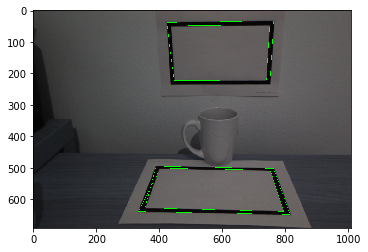

In [17]:
def sortRectanglePoints(points):
    points = np.reshape(points, (4,2))
    sortedByY = points[points[:,1].argsort()]
    upper = sortedByY[0:2]
    upper = upper[upper[:, 0].argsort()]
    lower = sortedByY[2:4]
    lower = lower[lower[:, 0].argsort()][::-1]
    
    points = np.concatenate((upper, lower), axis = 0)
    return points

def matchRectangles(rectangles):
    pl = []
    # Match The rectangles by hierarchy
    for _, contour, h in rectangles: # Inefficient nested loop, but it's only 4 elements so it's ok
        if h[2] == -1:
            for i2, contour2, _ in rectangles:
                if i2 == h[3]:
                    pl.append([contour, contour2])

    # Reshape the planes array and find the lowest y value
    plane1 = np.concatenate((pl[0][0], pl[0][1]), axis=0)
    plane1 = np.reshape(plane1, (8,2))
    minX1 = np.min(plane1[:,1]) # min y axis

    plane2 = np.concatenate((pl[1][0], pl[1][1]), axis=0)
    plane2 = np.reshape(plane2, (8,2))
    minX2 = np.min(plane2[:,1]) # min y axis

    # return Table - Wall based on the lowest y value
    return (plane2, plane1) if minX1 < minX2 else (plane1, plane2)


def findRectanglesOnFrame(frame, preciseCorners=True, debug=False):
    gFrame = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
    r, tFrame = cv.threshold(gFrame, 15, 255, cv.THRESH_BINARY)
    _, contours, hierarchy = cv.findContours(tFrame,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
    colorG = 255
    colorR = 0

    rectangles = []
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    for i, (contour, h) in enumerate(zip(contours, hierarchy[0])):
        perimeter = cv.arcLength(contour,True)
        epsilon = 0.005*perimeter
        approx = cv.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4 and perimeter > 20:
            if preciseCorners:
                corners = cv.cornerSubPix(tFrame, np.float32(approx), (3,3), (-1, -1), criteria)
                corners = np.int64(corners)
                corners = sortRectanglePoints(corners)
                rectangles.append((i, corners, h))
                frame = cv.drawContours(frame, [corners], -1, (0, colorG, colorR))
            else:
                approx = sortRectanglePoints(approx)
                rectangles.append((i, approx, h))
                frame = cv.drawContours(frame, [approx], -1, (0, colorG, colorR))
            colorG -= 75
            colorR += 75
          

    # plt.imshow(frame)
    # plt.show()
    if debug:
        cv.imshow('rectangles', frame)
        cv.imwrite('rectangles.png', frame)
        cv.waitKey(0)
        cv.destroyAllWindows()
    outName = './res/planes_precise.png' if preciseCorners else './res/planes_approx.png'
    #cv.imwrite(outName, frame)

    if len(rectangles) == 4:
        table, wall = matchRectangles(rectangles)  

        # print(table)
        # print()
        # print(wall)

        return table, wall
    else:
        print('Found a number of rectangles != 4:', len(rectangles))
        return None, None

def findRectangles(method=RECTANGLE_DEFAULT, iterations=RECTANGLE_ITERATIONS, debug=False):
    vid = cv.VideoCapture(VIDEO_NAME)
    ret, frame = vid.read()
    if ret:
        frame = undistort(frame)

    # find the corners by using one frame
    if ret and method == RECTANGLE_SINGLE_FRAME:
        table, wall = findRectanglesOnFrame(frame, preciseCorners=True, debug=debug)

    elif method == RECTANGLE_MULTI_FRAME:
        i = 0
        tables = []
        walls = []
        while ret and i < iterations:
            t, w = findRectanglesOnFrame(frame, preciseCorners=True, debug=debug)
            if t is not None and w is not None:
                tables.append(t)
                walls.append(w)
            i+=1
            ret, frame = vid.read()
            if ret:
                frame = undistort(frame)

        table = np.mean(np.array(tables), axis=0, dtype=np.int64)
        wall = np.mean(np.array(walls), axis=0, dtype=np.int64)

        
    else:
        print('Method not valid!', method)

    f = cv.drawContours(frame, [table, wall], -1, [0,255,0])
    plt.imshow(f)
    if debug:
        cv.imshow('avg', f)
        cv.waitKey(0)
        cv.destroyAllWindows()

    vid.release()
    return table, wall

table, wall = findRectangles(debug=True)

## Homography
Returns a 3x3 matrix, R1 R2 and T columns
the rows are x, y and constant

to calculate the point in the ideal plane, the formula of x is

https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#gafd3ef89257e27d5235f4467cbb1b6a63

R3 is the crossproduct between R1 and R2 and allows to understand the distance in X from the image plane
T represent the point in the ideal plane with coordinates of image plane

R3 se ha tutti gli elementi negativi vuol dire che il piano va di fronte a sinistra della camera
Se ha neg neg pos, vuol dire che fa up left far away from the camera
se ha neg pos neg, va down left to the camera
se ha pos neg neg, va sopra a destra verso la camera

In [18]:
# TODO revise the math in slide 11
def findPlanes(rectangle, mtxInv):
    # top-left, top-right, bottomo-right, bottom-left
    originalRectangle = np.array([[0,0], [25,0], [25, 13], [0, 13], [1,1], [24, 1], [24, 12], [1, 12]])

    # 3x3 matrix
    homography, _ = cv.findHomography(originalRectangle, rectangle)

    H = np.dot(mtxInv, homography)
    r1 = H[:, 0]
    r2 = H[:, 1]
    t = H[:, 2]

    s1 = np.linalg.norm(r1)
    s2 = np.linalg.norm(r2)
    s = (s1 + s2)/2.0
    
    r1 = r1/s1
    r2 = r2/s2
    r3 = np.cross(r1, r2)
    r3 = r3 / np.linalg.norm(r3)
    t = t/s
    
    print('plane normal: ', r3)
    print('plane point: ', t)
    
    return t, r3, homography
   


invMtx = np.linalg.inv(mtx)
print('Finding table plane...')
tableT, tableR, tableH = findPlanes(table, invMtx)
print('Finding wall plane...')
wallT, wallR, wallH = findPlanes(wall, invMtx)



Finding table plane...
plane normal:  [8.76697060e-04 9.35557030e-01 3.53174566e-01]
plane point:  [-15.75416594  -0.48165594  69.56479133]
Finding wall plane...
plane normal:  [ 0.06702576 -0.49504373  0.86627897]
plane point:  [-19.17346737 -31.89303107  95.10143442]


In [19]:
# get the box around a 4-sides polygon
def bBox(rect):
    minX = np.min(rect[:4, 0])
    maxX = np.max(rect[:4, 0])
    minY = np.min(rect[:4, 1])
    maxY = np.max(rect[:4, 1])
    return (minX, maxX, minY, maxY)

# find the points in a window of the mask
# then shifts the box to the original position
def getPointsInBox(mask, box):
    minX, maxX, minY, maxY = box
    x = mask[minY:maxY, minX:maxX]
    res = np.array(np.where(x == 255)) 
    res = np.transpose(res) + [minY, minX]
    return res


# Isolates the laser points in a frame
# return:
# - an array of points on the table
# - an array of points on the wall
# - an array of points between wall and table
# - a colored frame with the identified laser
def maskLaser(frame, tableBox, wallBox, betweenBox, cleanFrame, debug=False, method=LASER_MASK_DEFAULT):
    
    #######################
    # MASK BASED ON COLOR #
    #######################

    if method == LASER_MASK_COLOR:
        # alpha=1.8 is good
        f = cv.convertScaleAbs(frame, alpha=1.8, beta=0)
        f = cv.GaussianBlur(f, (3,3), 0)
        f = cv.cvtColor(f, cv.COLOR_BGR2HLS)
        

        lower_red = np.array([140, 45, 45])
        upper_red = np.array([175, 255, 255])

        mask = cv.inRange(f, lower_red, upper_red)

        # frame = cv.cvtColor(frame, cv.COLOR_BGR2HLS)
        # cleanFrame = cv.cvtColor(cleanFrame, cv.COLOR_BGR2HLS)

    
    if method == LASER_MASK_COLOR_2:
        # alpha=1.8 is good
        f = cv.convertScaleAbs(frame, alpha=2.5, beta=-100)
        f = cv.GaussianBlur(f, (3,3), 0)
        # cv.imshow('color', f)
        # cv.waitKey(1)
        f = cv.cvtColor(f, cv.COLOR_BGR2HLS)
        
        lower_red = np.array([140, 50, 65])
        upper_red = np.array([175, 255, 255])

        mask = cv.inRange(f, lower_red, upper_red)
        mask = cv.medianBlur(mask, 3)


    ############################
    # MASK BASED ON DIFFERENCE #
    #      WITH BASE FRAME     #
    ############################

    if method == LASER_MASK_DIFFERENCE:
        diff = cv.absdiff(frame[:, :, :], cleanFrame[:, :, :])
        diff = cv.convertScaleAbs(diff, alpha=3, beta=0)

        diff = cv.cvtColor(diff, cv.COLOR_BGR2HLS)
        #diff = cv.GaussianBlur(diff, (3,3), 0)
        # diff = cv.medianBlur(diff, 3)
        
        # works well with firstFrame = cleanFrame
        lower_diff = np.array([0, 45, 100])
        upper_diff = np.array([255, 150, 255])

        mask = cv.inRange(diff, lower_diff, upper_diff)
        mask = cv.medianBlur(mask, 3)

        diff = cv.cvtColor(diff, cv.COLOR_HLS2BGR)

    if debug:
        cv.imshow('mask', mask)
        cv.waitKey(1)

    # f = cv.bitwise_and(f, f, mask = mask)

    laserPointsT = getPointsInBox(mask, tableBox)
    laserPointsW = getPointsInBox(mask, wallBox)
    laserPointsB = getPointsInBox(mask, betweenBox)

    coloredFrame = cv.convertScaleAbs(frame, alpha=0.5, beta=-25)

    for c in laserPointsT:
        coloredFrame[c[0]][c[1]] = [0,255,255]
    for c in laserPointsW:
        coloredFrame[c[0]][c[1]] = [0,255,255]
    for c in laserPointsB:
        coloredFrame[c[0]][c[1]] = [0,255,0]

    if debug:
        cv.imshow('frame + laser', coloredFrame)
        cv.waitKey(1)

    return laserPointsT, laserPointsW, laserPointsB, coloredFrame


#table, wall = findRectangles()

tableBox = bBox(table)
wallBox = bBox(wall)

# x-axis = from min of the two boxes to the max of the two boxes
# y-axis = the area between the two boxes
betweenBox = (min(tableBox[0], wallBox[0]), max(tableBox[1], wallBox[1]), wallBox[3], tableBox[2])



***Test laser mask***\
Goes through the whole video just and show the laser identification

In [20]:
if False:
    vid = cv.VideoCapture(VIDEO_NAME)
    ret, frame = vid.read()
    frame = undistort(frame)
    cleanFrame = frame.copy()

    # cleanFrame1 = frame.copy()
    # cleanFrame2 = frame.copy()
    # cleanFrame3 = frame.copy()

    #for i in range(400):
    while ret == True:
        _, laserPointsT, laserPointsW, laserPointsB = maskLaser(frame, tableBox, wallBox, betweenBox, cleanFrame, imshow=True, method=LASER_MASK_COLOR_2)
        cleanFrame = frame.copy()
        # cleanFrame1 = cleanFrame2.copy()
        # cleanFrame2 = cleanFrame3.copy()
        # cleanFrame3 = frame.copy()
        ret, frame = vid.read()
        if ret:
            frame = undistort(frame)
        if cv.waitKey(25) & 0xFF == ord('q'):
            ret = False
            break
    cv.destroyAllWindows()
    vid.release()

### 2D point -> 3D point

We can consider each red dot as ray from the camera to the dot and its position is given by `ray(t) = (xt, yt, t)`.

The `x` and `y` of the 2D point are known, we just need to compute `t`.
This value is given by `t = -D/(Ax + By + Cz)`

The plane equation is given by `Ax + By + Cz + D = 0`, where `D` is the distance between the camera and the plane.\
We can compute `Ax + By + Cz` by performing the dot product between the `plane norm` and the point itself.\
(The point has to be normalized first by adding 1 as 3rd dimension)\


In [21]:
# TODO TO FIX
def get3DPoints(points2D, plane_norm, plane_point, invK):
    
    if(points2D.size < 1):
        return points2D
    
    plane_d = np.dot(plane_point, plane_norm)
    
    # adds a third dimension to a 2D point
    normalize = lambda x,invK : np.dot(invK, np.array([x[1], x[0], 1]))

    # find the intersection between the ray and the plane (depth of the point)
    t = lambda norm,d,normalized_point : (d)/(np.dot(norm, normalized_point))

    # normalize the point with the depth t
    point3d = lambda t,normalized_point : np.array([normalized_point[0]*t, normalized_point[1]*t, t])
                                    
    points2D = np.array([normalize(point, invK) for point in points2D])
    
    points3D = np.array([point3d(t(plane_norm, plane_d, point), point) for point in points2D])
            
    return points3D

### Find laser plane
In order to identify a plane, we need at least 3 (non aligned) points.\
Since have the points in the wall plane and the points on the table plane are aligned/noisy,\
We can compute the centroid between the two "lines", that still belongs for sure to the plane,\
but that will help computing a more precise plane.

Then by using the Principal Component Analysis and by taking the smallest eigenvector\
(that is the one that have the most information) we can find the norm of the plane.

In [22]:
# given the 3D points of the wall laser and 
def getLaserPlane(points3D):
    
    if(points3D.size < 1):
        return np.array([]), np.array([])
    
    centroid = np.mean( points3D, axis=0 )
    
    # pca
    cov_mtx = np.cov(np.transpose(points3D-centroid))
    eigenvalues, eigenvectors = np.linalg.eig(cov_mtx)
    
    idx = np.argmin( eigenvalues);
    
    # Z value is the smallest, that is the norm
    min_eigvect = eigenvectors[:,idx]

    return centroid, min_eigvect

In [44]:
def writePly(points):
    file = open(f'{SCAN_NAME}', "w")
    # Write header
    file.write(f'ply\nformat ascii 1.0\ncomment author: Fabio Rosada (851772)\ncomment object: {OBJECT_NAME}\n')

    file.write(f'element vertex {str(points.shape[0]-1)}\n')
    file.write('property float x\nproperty float y\nproperty float z\nend_header\n')
    
    # write points
    for p in points:
        file.write(f'{str(p[0])} {str(p[1])} {str(p[2])}\n')
    file.close()

In [41]:
def centerGeometry(points):
    return points - np.mean(points, axis=0)

def rotateGeometry(points):
    return points

# MAIN

In [45]:
vid = cv.VideoCapture(VIDEO_NAME)


vis = o3d.visualization.Visualizer()
is_window_opened = False


printablePoints = np.empty([0,3])
renderPoints = np.empty([0,3])

ret, frame = vid.read()
cleanFrame = undistort(frame)
i=0
while ret:
    frame = undistort(frame)
    laserPointsT, laserPointsW, laserPointsB, coloredFrame = maskLaser(frame, tableBox, wallBox, betweenBox, cleanFrame)
    cleanFrame = frame.copy()

    tablePoints = get3DPoints(laserPointsT, tableR, tableT, invMtx)
    wallPoints = get3DPoints(laserPointsW, wallR, wallT, invMtx)

    if tablePoints.size > 10 and wallPoints.size > 10:
        points = np.concatenate((wallPoints, tablePoints), axis = 0)

        if INCLUDE_PLANES_IN_SCAN:
            printablePoints = np.concatenate((printablePoints, points), axis = 0)
            renderPoints = np.concatenate((renderPoints, points), axis = 0)
        
        laser_point, laser_norm = getLaserPlane(points)
        laserPointsB = get3DPoints(laserPointsB, laser_norm, laser_point, invMtx)
    
        if laserPointsB.size > 1:
            printablePoints = np.append(printablePoints, laserPointsB, axis = 0)
            renderPoints = np.append(renderPoints, laserPointsB, axis = 0)
    
    if i % 2 == 0 and renderPoints.shape[0] > 0:
        if not is_window_opened:
            vis.create_window()
            is_window_opened = True
            
        renderPoints = renderPoints*[1, -1, -1]
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(renderPoints)
        vis.add_geometry(pcd)
        vis.update_geometry()
        vis.poll_events()
        vis.update_renderer()
        renderPoints = np.empty([0,3])
    
    i = i+1

    cv.imshow('Frame', coloredFrame)
    # Press Q on keyboard to  exit
    if cv.waitKey(25) & 0xFF == ord('q'):
        ret = False
        break

    ret, frame = vid.read()

vid.release()
vis.destroy_window()
cv.destroyAllWindows()
printablePoints = centerGeometry(printablePoints)
printablePoints = rotateGeometry(points)
writePly(printablePoints)   # the multiplication 

(316113, 3)
(316113, 3)


In [27]:
import open3d as o3d
pcd = o3d.io.read_point_cloud(SCAN_NAME)
o3d.visualization.draw_geometries([pcd])